In this notebook, we will solve a simple duopoly model using python. This illustrates how to optimize in python and how to solve equations. We do this both symbolically and numerically. There are a lot of mathematical functions in python, but for economists the two most important ones are: optimization (utility, profit etc. maximization) and fixed points (equilibrium). So we focus on these in this notebook.




# Model



The set up is the following standard Cournot model. We work with a linear demand curve $p_i(q_i,q_j)=1-a q_i - b q_j$ and costs $c_i(q)=c_i q$, where $q_i$ denotes firm $i$'s output on the market.

Firm $i$'s profit is written as $\pi(q_i,q_j)=(1-a q_i-b q_j)q_i-c_i q_i$ with $j \neq i$. The way we usually solve this analytically is as follows.

The two first order conditions for firms 1 and 2 can be written as:

$$
1-2a q_1-b q_2-c_1 = 0
$$

and

$$
1-2 a q_2-b q_1-c_2 = 0
$$

Then we can solve these two equations in the unknowns $q_1,q_2$. However, we usually take a step in between and define the reaction functions. That is, we solve the optimal $q_i$ as a function of $q_j$:

$$
q_i = \frac{1}{2a}(1-c_i-b q_j)
$$

Or, equivalently, we define $i$'s reaction function as 

$$
R_i(q_j) = \frac{1}{2a}(1-c_i-b q_j)
$$

We have an equilibrium if $q_1 = R_1(q_2)$ and $q_2 = R_2(q_1)$. Or in matrix notation, the equilibrium is given by $q_1,q_2$ such that

$$

\begin{pmatrix} q_1\\ q_2\end{pmatrix} = \begin{pmatrix} R_1(q_2)\\ R_2(q_1)\end{pmatrix}

$$

If both firms have the same costs $c_1=c_2$, there is a symmetric equilibrium given by $q=R(q)$.

To calculate the equilibrium, we need to find a so called fixed point of the vector function $R(q)$. This can be seen as follows.

Define the function (or mapping) $q \rightarrow R(q)$ with $q \in \Re^2$ and 

$$
R(q) = \begin{pmatrix} R_1(q_2)\\ R_2(q_1)\end{pmatrix}
$$

A fixed point of this function is defined as a vector $q$ such that $q=R(q)$. In words, $q_1$ is the optimal reaction to $q_2$ and $q_2$ is the optimal reaction to $q_1$. That is, the vector $q$ is a Nash equilibrium. Each firm $i$ chooses its optimal output level $q_i$, given the choice by the other firm $q_j$.




# solve model symbolically



One way to solve such a duopoly model in python is to use the `sympy` library which allows us to do symbolic math. We import this library.



In [1]:
from sympy import *

We define variables that we want to use as symbols.



In [1]:
q1, q2 = symbols('q1 q2')
a,b = symbols('a b')
c1, c2 = symbols('c1 c2')

We define the (inverse) demand function and the cost function. Although, these look like "normal" python functions, python actually "understands" these functions as symbolic functions. The reason is that they are defined using the symbols that we just defined.



In [1]:
def p(q1,q2):
    return 1-a* q1 - b* q2

def cost(q,c):
    return c*q

With these functions, we can define the profit function of a firm with cost level $c$ that produces output $q_1$ while its competitor produces $q_2$.

Once the profit function is defined, we derive the first order conditions. That is, we differentiate the profit of firm $i$ with respect to the output level of firm $i$, $q_i$.



In [1]:
def profit(q1,q2,c):
    return p(q1,q2)*q1 - cost(q1,c)

foc1 = diff(profit(q1,q2,c1),q1)
foc2 = diff(profit(q2,q1,c2),q2)

---

**Exercise**

Use the function `diff` to show that profits of firm $i$ are concave in $q_i$.

---

In equilibrium the first order conditions for both firms should equal 0. Hence, we can solve the system of equation `foc1, foc2` with respect to $q_1,q_2$.



In [1]:
solve([foc1, foc2], [q1, q2])

lion-low-oxygen-magnesium

{q1: (-2*a*(c1 - 1) + b*(c2 - 1))/(4*a**2 - b**2),
 q2: (-2*a*(c2 - 1) + b*(c1 - 1))/(4*a**2 - b**2)}

---

**Exercise**

Define a different demand and/or cost function and calculate the equilibrium again. Note that for some demand and cost functions, an analytical solution is no longer available.

---

With `sympy` you can differentiate and integrate your favourite functions.



In [1]:
from sympy import *

x = symbols('x')
def f(x):
    return x**2

print(diff(f(x),x))
print(integrate(f(x),x))

two-lima-fish-sodium

2*x
x**3/3

---

**Exercise**

Find the derivative and integral of $e^x$ (use `exp(x)`), $cos(x)$ and $ln(x)$.

---




# solve model numerically



Sometimes you are not interested in the analytical solution, but just want to know how the equilibrium varies with a parameter. We will make a graph where the equilibrium output levels vary with one of the firm's cost level. We start by importing some libraries.



In [1]:
# First lets clear all previous python imports and variables by resetting the python kernel.
%reset -f

from scipy import optimize,arange
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

We define the (inverse) demand and cost functions as above. But now $q1,q2,c$ are normal python variables and not symbols.



In [1]:
def p(q1,q2):
    return 1-a*q1-b*q2

def costs(q,c):
    return c*q

def profits(demand_function,cost_function,c,q1,q2):
    return demand_function(q1,q2)*q1-costs(q1,c)

Note that the function `profits` above takes the functions `demand_function` and `cost_function` as arguments, besides the variables `c,q1,q2`.

---

**Exercice**

Try to take the derivative of $costs(q,c)$ with respect to $q$ using `diff` (that is, after importing `sympy`).

---

As we are doing a numerical analysis here, we need to choose values for the demand parameters $a,b$.



In [1]:
a = 1
b = 1

Each firm maximizes its profits. However, python does not feature maximization routines; there are only minimization routines. Hence, if we want to maximize profits, we need to minimize `minus profits`. In the following code block, we minimize $-profits$ for firm 1 given an output level $q_2$ for the other firm. This is, in fact, firm 1's reaction function. From `optimize` we use the function `fminbound` to find the minimum of $-profits$. We specify the function `profits`, with functions `p` and `costs` as defined above. The function call to `reaction` specifies `q2` and `c1`. The only variable left to vary is $q_1$ which we denote by $x$ in the "lambda"-function. Further, we specify the interval where the optimal $q_1$ has to be found; $[0,1]$ in this case. Google to see what `full_output` does in this case.

Then we define the function `fixed_point` which is the equivalent of $q-R(q)$ above. Note that the function `reaction` can be used for both firm 1 and firm 2; only the arguments differ for the firms, but the function itself is the same.

The function `fixed_point` takes two (vector) arguments: a vector $q$ of output levels and $c$ of cost levels. With the indexing conventions in python, $q[0]$ is the first element of $q$ and hence a natural choice for $q_1$; similarly, $q[1]$ corresponds to $q_2$. The same logic applies to $c$.

From `optimize` (which was imported above from `scipy`), we use `fsolve` to find the $q$ where `fixed_point(q,c)` equals 0. We provide an initial guess for this vector $q$. We solve the model for the case where $c_1=c_2=0$ (with $a=b=1$ you should be able to dream the answer&#x2026;)



In [1]:
def reaction(q2,c1):
    q1 =  optimize.fminbound(lambda x: -profits(p,costs,c1,x,q2),0,1,full_output=1)
    return q1[0]

def fixed_point(q,c):
    return [q[0]-reaction(q[1],c[0]),q[1]-reaction(q[0],c[1])]

initial_guess = [0,0]

optimize.fsolve(lambda q: fixed_point(q,[0,0]), initial_guess)

romeo-snake-neptune-burger

array([ 0.33333333,  0.33333333])

---

**Exercise**

Solve the model for $c_1 = 0.1, c_2 = 0.2$.

---

Now that we have solved the model, we can plot the output level of firms' 1 and 2 as a function of $c_1$.



seventeen-low-pennsylvania-bravo



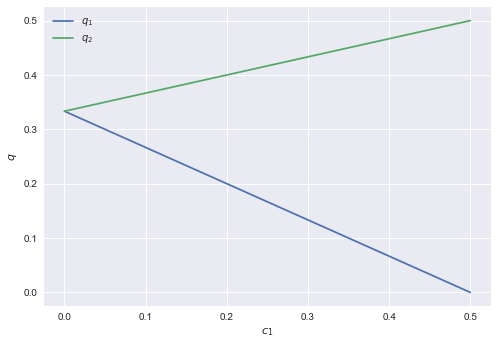

In [1]:
range_c = arange(0,0.51,0.01)
range_q = [optimize.fsolve(lambda q: fixed_point(q,[c,0]), [0,0]) for c in range_c]
plt.style.use('seaborn')
plt.clf()
plt.plot(range_c,array(range_q)[:,0], label = '$q_1$')
plt.plot(range_c,array(range_q)[:,1], label = '$q_2$')
plt.xlabel('$c_1$')
plt.ylabel('$q$')
plt.legend()
plt.savefig('Cournot.png')

![img](./Cournot.png)

---

**Exercise**

Copy the code above in a new cell and adjust it such that you can plot $q_1,q_2$ as a function of $b \in [0,a]$. First, do this for the symmetric case with $c_1=c_2=0$. Then make a new plot where $c_1 \neq c_2$.

---

